# n-step Tree backup

Implementing n-step Tree backup introduced [**HERE**](http://demiledge.com/artificialIntelligence/nstepsTD.php#treebackup).

In this example I want to start to use the *gym* library developed by OpenAI. The environment is called "Taxi-v2" and the agent has to move to one of the four location: *R,G,Y or B* and pick up a client, then move to another of the four location and drop-off the client. If the agent select the pick-up or drop-off action outside one of the 4 location, a reward of **-10** is returned. At every timestep the reward is **-1** and **+20** for correct pick-up and drop-off.
The possible actions are 6: **up,down,left,right,pickup,drop-off**

In [2]:
import gym
env=gym.make("Taxi-v2")#import the game

print(env.action_space)
print(env.observation_space)
env.render()

Discrete(6)
Discrete(500)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Agent

Let's define our agent. 

The hyperparamaters are assigned dynamically for test purposes.

Suppose that our agent is 3-step TreeBackup. So, at the 4th timestep, we have all the *q(s,a)* and *r* required to update the *q(s,a)* encountered at the first timestep. We work backwards, the take the fourth *qs,a)*, compute the expectation, multiply by the discount and add the reward obtained when reached this *q(s,a)*. Now, for every other *q(s,a)* we multiply *G* by the prob of the action selected, sum the others weighted actions, multiply everything by the *discount* and add the *reward*.

Once the game is finished, before to reset it and start again, we have to empty the list that stores the *q(s,a)*, because the last *n* steps are not updated, so we use the same formula, with the only execption that where we don't have the necessary info, we use 0. For example, the last *3 steps* will not be update using the expectation of the fourth *q(s,a)* occured after them because we have already finished the game. So, we use a 0.

In [201]:
import numpy as np
import random

def agent(epsilon,nsteps,alpha, decay):
    QTable=np.zeros([500,6])

    episodes=1000
    epsilon=epsilon
    nsteps=nsteps
    alpha=alpha
    discount=0.99
    epsilon_decay=0.99

    stepsEpisode=[]
    rewardsEpisode=[]

    def policy(state):
        if random.random()<epsilon:
            return env.action_space.sample()
        else:
            bestActions=np.argwhere(state==np.amax(state))
            return int(np.random.choice(np.reshape(bestActions, -1)))

    def computeExpectation(actions):
        #retrieve the actions with highest value and pick just 1 randomly
        bestAction=np.random.choice(np.reshape(np.argwhere(actions==np.amax(actions)), -1))
        probs=[]
        for idx,act in enumerate(actions):
            if idx==bestAction:
                prob=(1-epsilon) + (epsilon/6)
                probs.append(prob)
            else:
                probs.append(epsilon/6)
        return probs
            
        
    for episode in range(episodes):
        valueFunctions=[]
        rewards=[]

        d=False
        totRewards=0
        step=0

        s=env.reset()

        action=policy(QTable[s])

        while not(d):
            #env.render()
            s1,r,d,_=env.step(action)

            valueFunctions.append([s,action])
            rewards.append(r)

            nextAction=policy(QTable[s1])

            if step>=nsteps:
                G=0
                #start from the last state stored and iterate backward 1 by 1 until the state 0 excluded
                #which is the state that is going to be update
                for t in range(nsteps, 0 ,-1):
                    #retrieve the idx of the action executed at the state s'
                    actionExecuted=valueFunctions[t][1]
                    #retrieve the s'
                    state=valueFunctions[t][0]

                    if t==nsteps:
                        #if it is the last state, compute expectation across all actions
                        actionProbs=computeExpectation(QTable[state])
                        expectation=np.sum(actionProbs*QTable[state])
                        #compute last lambda (lambda t+2 if you look the article)
                        G=rewards[t-1] + discount * expectation
                    else:
                        #if not last state, compute expectation excluded the action selected 
                        actionProbs=computeExpectation(QTable[state])
                        expectation=0
                        for idx,prob in enumerate(actionProbs):
                            if idx==actionExecuted:
                                expectation+= prob * G
                            else:
                                expectation += prob * QTable[state][idx]
                        #compute lambda t+1
                        G=rewards[t-1] + discount * expectation

                #update q(s,a) (state 0)
                qs=valueFunctions[0][0]
                qa=valueFunctions[0][1]
                QTable[qs][qa]=QTable[qs][qa] + alpha * (G - QTable[qs][qa])

                del valueFunctions[0]
                del rewards[0]

            #if the game is finished, finish to update the states
            if d:
                while len(valueFunctions)>0:
                    G=0
                    elementsLeft=len(valueFunctions)-1
                    for t in range(elementsLeft,0,-1):
                        actionExecuted=valueFunctions[t][1]
                        state=valueFunctions[t][0]

                        actionProbs=computeExpectation(QTable[state])
                        expectation=0
                        for idx,prob in enumerate(actionProbs):
                            if idx==actionExecuted:
                                expectation+= prob * G
                            else:
                                expectation += prob * QTable[state][idx]
                        #compute lambda 
                        G=rewards[t-1] + discount * expectation

                    #update q(s,a)
                    qs=valueFunctions[0][0]
                    qa=valueFunctions[0][1]
                    QTable[qs][qa]=QTable[qs][qa] + alpha * (G - QTable[qs][qa])

                    del valueFunctions[0]
                    del rewards[0]


            action=nextAction
            s=s1

            step+=1
            totRewards+=r

        stepsEpisode.append(step)
        rewardsEpisode.append(totRewards)
        
        if decay:
            epsilon=epsilon*epsilon_decay
        
    #training finished, return results
    return stepsEpisode, rewardsEpisode

## Training

Now that the agent is ready and able to adapt to different *n-steps*. We can test different parameters, I want to pickup just 3 combinations of hyperparameters. Precisely, the combination that obtained the highest summed reward throughout the entire training for each *n-step* setting. 

In [202]:
epsilonsList=[0.1,0.2,0.3,0.4]
nstepsList=[1,3,7]
alphaList=[0.2,0.4,0.6,0.8,1]

#store the top 2 best settings for each nstep algorithm
bestAgentSettings=[]
agentStepsResults=[]
agentRewardsResults=[]

for nsteps in nstepsList:
    print("\n**** STARTING SET ****\n")
    nstepBestReward=[]
    nstepBestSettings=[]
    nstepStepsResults=[]
    nstepRewardsResults=[]
    for ep in epsilonsList:
        for alpha in alphaList:
            status=True
            for i in range(2):
                st, rw=agent(ep,nsteps,alpha, status)
                print("Training agent with nsteps={}, e={}, alpha={}, decay={}".format(nsteps,ep,alpha,str(status)))
                if len(nstepBestReward)>=1:
                    minValue=np.amin(nstepBestReward)
                    if np.sum(rw)>minValue:
                        position=int(np.argwhere(nstepBestReward==minValue))
                        #remove the old agent, add the new one
                        nstepBestReward[position]=np.sum(rw)
                        nstepBestSettings[position]=[ep,nsteps,alpha,str(status)]
                        nstepStepsResults[position]=st
                        nstepRewardsResults[position]=rw
                else:
                    nstepBestReward.append(np.sum(rw))
                    nstepBestSettings.append([ep,nsteps,alpha,str(status)])
                    nstepStepsResults.append(st)
                    nstepRewardsResults.append(rw)
                status=not(status)
                
    #store the 2 best for every nstep algorithm
    for idx,_ in enumerate(nstepBestSettings):
        bestAgentSettings.append(nstepBestSettings[idx])
        agentStepsResults.append(nstepStepsResults[idx])
        agentRewardsResults.append(nstepRewardsResults[idx])


**** STARTING SET ****

Training agent with nsteps=1, e=0.1, alpha=0.2, decay=True
Training agent with nsteps=1, e=0.1, alpha=0.2, decay=False
Training agent with nsteps=1, e=0.1, alpha=0.4, decay=True
Training agent with nsteps=1, e=0.1, alpha=0.4, decay=False
Training agent with nsteps=1, e=0.1, alpha=0.6, decay=True
Training agent with nsteps=1, e=0.1, alpha=0.6, decay=False
Training agent with nsteps=1, e=0.1, alpha=0.8, decay=True
Training agent with nsteps=1, e=0.1, alpha=0.8, decay=False
Training agent with nsteps=1, e=0.1, alpha=1, decay=True
Training agent with nsteps=1, e=0.1, alpha=1, decay=False
Training agent with nsteps=1, e=0.2, alpha=0.2, decay=True
Training agent with nsteps=1, e=0.2, alpha=0.2, decay=False
Training agent with nsteps=1, e=0.2, alpha=0.4, decay=True
Training agent with nsteps=1, e=0.2, alpha=0.4, decay=False
Training agent with nsteps=1, e=0.2, alpha=0.6, decay=True
Training agent with nsteps=1, e=0.2, alpha=0.6, decay=False
Training agent with nsteps=

## Display results

In [203]:
#CALCULATE MOVING AVERAGE OF WINDOW=5
def movingAverage(data, size=50):
    averagedData=[]
    for idx, item in enumerate(data,1):
        if idx>=size:
            movAvg=np.sum(data[idx-size:idx])/size
        else:
            movAvg=np.sum(data[:idx])/idx
        averagedData.append(movAvg)
        
    return averagedData

newAgentStepsResults=[]
newAgentRewardsResults=[]
for idx, element in enumerate(agentStepsResults):
    newAgentStepsResults.append(movingAverage(agentStepsResults[idx]))
    newAgentRewardsResults.append(movingAverage(agentRewardsResults[idx]))

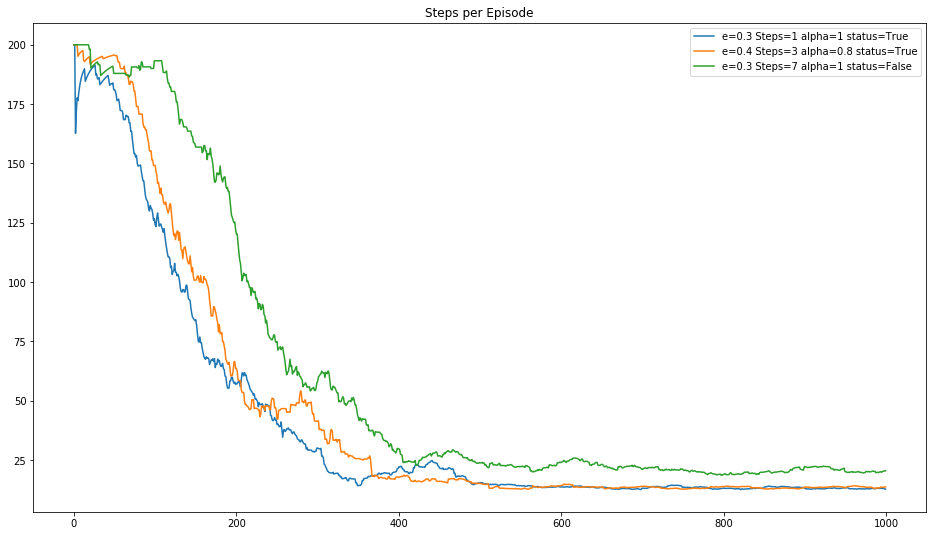

In [204]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16,9]
#f=plt.figure()
x=[i for i in range(1000)]

#plt1=f.add_subplot(2,1,1)
for idx,agent in enumerate(bestAgentSettings):
    string="e="+str(agent[0])+" Steps="+str(agent[1])+" alpha="+str(agent[2])+" status="+str(agent[3])
    plt.plot(x, newAgentStepsResults[idx], label=string)
plt.title("Steps per Episode")
plt.legend(loc=0)

plt.show()

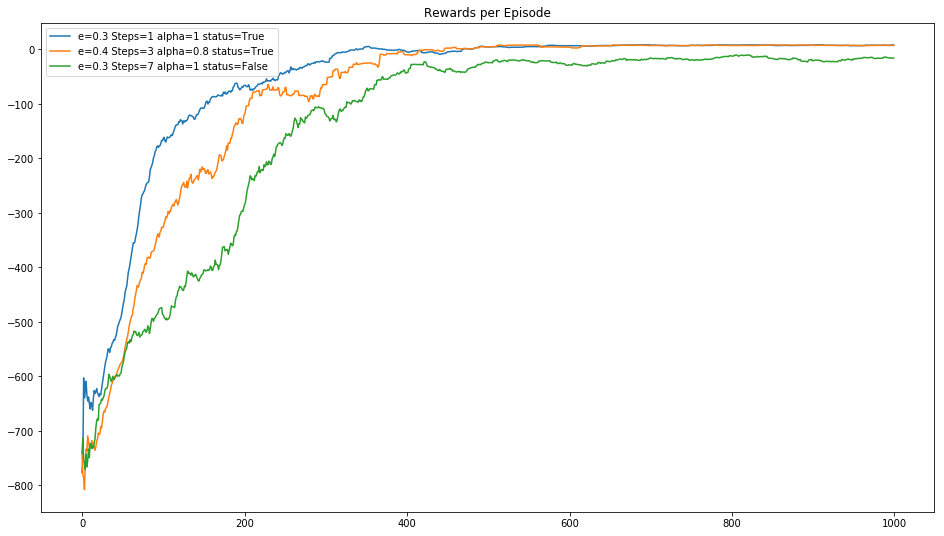

In [205]:
for idx,agent in enumerate(bestAgentSettings):
    string="e="+str(agent[0])+" Steps="+str(agent[1])+" alpha="+str(agent[2])+" status="+str(agent[3])
    plt.plot(x, newAgentRewardsResults[idx], label=string)
            
plt.title("Rewards per Episode")
plt.legend(loc=0)

plt.show()

All the agents have an high *alpha* parameter. This is due to the fact that calculating the *expectation* allows to reduce the possibility that the value of *q(s,a)* "bounces" between different values. In other words, the *expectation* reduces the variance of *q(s,a)* so we can increase *alpha* to speed-up the learning process.
Moreover, they all have a *epsilon* around 0.3/0.4 with *epsilon decay* activated. Just the *7-step agent* performed better without *epsilon decay*. If it is set to true, the *epsilon* in the e-greedy policy is reduced over time reducing the exploration.

Interestigly, the particular case where the backup tree is just one step (**Expected SARSA agent**) performed better that *3-step* and *7-step* agents. I'm not suprised about the *7-step agent*. In a 5x5 grid world, maybe *7-steps* are too much, but the *3-step agent* is not able to perform better than **Expected SARSA** until convergence (around 400 episode). However, looking at the plot of the timesteps per episode, *3-step agent* seems to found a better policy that *expected sarsa*, infact, for a while it finished games more quickly and the orange line in the *rewards per episode* around the 200 episode increase exponentially. I came up with 2 possible solutions to explain why *expected SARSA* outperform *3-step agent*. One involve the fact that maybe, due to the fact that there isn't a single goal state but 4, updating more than one step, somehow is not convenient. The other reason could be due to the fact that in this kind of environments where the value of the state depends on a particular situation, it is more efficient keep small updates. In the maze environemnt, the agent has to define a path that in order to reach the terminal state which is determineted fro the beginning to the end of the training. So, random events or particular situations chan occur.